# JAX 101 - 06 Working with PyTrees
Link to the original JAX tutorial: https://jax.readthedocs.io/en/latest/jax-101/05.1-pytrees.html

## Part 0 - Data Owner Setup

In [1]:
# Import the necessary libraries
import syft as sy
sy.requires(">=0.8,<0.9")

import jax
import jax.numpy as jnp
import numpy as np

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /


✅ The installed version of syft==0.8.1b3 matches the requirement >=0.8 and the requirement <0.9


In [2]:
# Launch the domain
node = sy.orchestra.launch(name="test-domain-1", reset=True, dev_mode=True)
data_owner_client = node.login(email="info@openmined.org", password="changethis")

SQLite Store Path:
!open file:///var/folders/sz/hkfsnn612hq56r7cs5rd540r0000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite



## Part 1 - Data Scientist

In [3]:
# Register a client to the domain
node = sy.orchestra.launch(name="test-domain-1")
data_scientist_client = node.client
data_scientist_client.register(name="Jane Doe", email="jane@caltech.edu", password="abc123", institution="Caltech", website="https://www.caltech.edu/")
data_scientist_client.login(email="jane@caltech.edu", password="abc123")

SQLite Store Path:
!open file:///var/folders/sz/hkfsnn612hq56r7cs5rd540r0000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite



<SyftClient - test-domain-1 <7bca415d13ed4ec881f0d0aede098dbb>: PythonConnection>

In [4]:
# Create a function for code execution
# ATTENTION: ALL LIBRARIES USED SHOULD BE DEFINED INSIDE THE FUNCTION CONTEXT!!!

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def pytree_examples():
    import jax
    import jax.numpy as jnp

    example_trees = [
        [1, 'a', object()],
        (1, (2, 3), ()),
        [1, {'k1': 2, 'k2': (3, 4)}, 5],
        {'a': 2, 'b': (2, 3)},
        jnp.array([1, 2, 3]),
    ]

    # Let's see how many leaves they have:
    for pytree in example_trees:
        leaves = jax.tree_util.tree_leaves(pytree)
        print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def common_pytree_functions():
    list_of_lists = [
        [1, 2, 3],
        [1, 2],
        [1, 2, 3, 4]
    ]

    list_tree_map = jax.tree_map(lambda x: x*2, list_of_lists)
    
    another_list_of_lists = list_of_lists
    another_list_tree_map = jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)
    return list_tree_map, another_list_tree_map
    
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def ml_model():
    import numpy as np
    import jax
    import jax.numpy as jnp

    def init_mlp_params(layer_widths):
        params = []
        for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
            params.append(
                dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                    biases=np.ones(shape=(n_out,))
                    )
            )
        return params

    params = init_mlp_params([1, 128, 128, 1])
    print("Shapes:\n", jax.tree_map(lambda x: x.shape, params))

    def forward(params, x):
        *hidden, last = params
        for layer in hidden:
            x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
        return x @ last['weights'] + last['biases']

    def loss_fn(params, x, y):
        return jnp.mean((forward(params, x) - y) ** 2)

    LEARNING_RATE = 0.0001

    @jax.jit
    def update(params, x, y):
        grads = jax.grad(loss_fn)(params, x, y)
        # Note that `grads` is a pytree with the same structure as `params`.
        # `jax.grad` is one of the many JAX functions that has
        # built-in support for pytrees.

        # This is handy, because we can apply the SGD update using tree utils:
        return jax.tree_map(
            lambda p, g: p - LEARNING_RATE * g, params, grads
        )
    import matplotlib.pyplot as plt

    xs = np.random.normal(size=(128, 1))
    ys = xs ** 2

    for _ in range(1000):
        arams = update(params, xs, ys)

    plt.scatter(xs, ys)
    plt.scatter(xs, forward(params, xs), label='Model prediction')
    plt.legend()
    return params
    
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def custom_pytree_nodes():
    import jax
    class MyContainer:
        """A named container."""

        def __init__(self, name: str, a: int, b: int, c: int):
            self.name = name
            self.a = a
            self.b = b
            self.c = c
    print(jax.tree_util.tree_leaves([
            MyContainer('Alice', 1, 2, 3),
            MyContainer('Bob', 4, 5, 6)
        ]))
    
    try:
        print(jax.tree_map(lambda x: x + 1, [
            MyContainer('Alice', 1, 2, 3),
            MyContainer('Bob', 4, 5, 6)
        ]))
    except Exception as e:
        print(e)
        
    from typing import Tuple, Iterable

    def flatten_MyContainer(container) -> Tuple[Iterable[int], str]:
        """Returns an iterable over container contents, and aux data."""
        flat_contents = [container.a, container.b, container.c]

        # we don't want the name to appear as a child, so it is auxiliary data.
        # auxiliary data is usually a description of the structure of a node,
        # e.g., the keys of a dict -- anything that isn't a node's children.
        aux_data = container.name
        return flat_contents, aux_data

    def unflatten_MyContainer(
        aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
        """Converts aux data and the flat contents into a MyContainer."""
        return MyContainer(aux_data, *flat_contents)

    jax.tree_util.register_pytree_node(
        MyContainer, flatten_MyContainer, unflatten_MyContainer)

    return jax.tree_util.tree_leaves([
        MyContainer('Alice', 1, 2, 3),
        MyContainer('Bob', 4, 5, 6)
    ])

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def gotchas():
    import jax
    import jax.numpy as jnp
    a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

    # Try to make another tree with ones instead of zeros
    shapes = jax.tree_map(lambda x: x.shape, a_tree)
    print(jax.tree_map(jnp.ones, shapes))
    print(jax.tree_util.tree_leaves([None, None, None]))

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def patterns():
    def tree_transpose(list_of_trees):
        """Convert a list of trees of identical structure into a single tree of lists."""
        return jax.tree_map(lambda *xs: list(xs), *list_of_trees)


    # Convert a dataset from row-major to column-major:
    episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
    print(tree_transpose(episode_steps))
    
    print(jax.tree_transpose(
        outer_treedef = jax.tree_structure([0 for e in episode_steps]),
        inner_treedef = jax.tree_structure(episode_steps[0]),
        pytree_to_transpose = episode_steps
    ))

[1, 'a', <object object at 0x1022f7e70>]      has 3 leaves: [1, 'a', <object object at 0x1022f7e70>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int64)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int64)]
Shapes:
 [{'biases': (128,), 'weights': (1, 128)}, {'biases': (128,), 'weights': (128, 128)}, {'biases': (1,), 'weights': (128, 1)}]
[<__main__.custom_pytree_nodes.<locals>.MyContainer object at 0x13b4a7e50>, <__main__.custom_pytree_nodes.<locals>.MyContainer object at 0x13b4a7a00>]
unsupported operand type(s) for +: 'MyContainer' and 'int'
[(DeviceArray([1., 1.], dtype=float64), DeviceArray([1., 1., 1.], dtype=float64)), (DeviceArray([1., 1., 1.], dtype=float64), DeviceArray([1., 1., 1., 1.], dtype=float64))]
[]
{'obs': [3, 4], 't': [1, 2]}
{'obs': [3, 4], 't': [1, 2]}


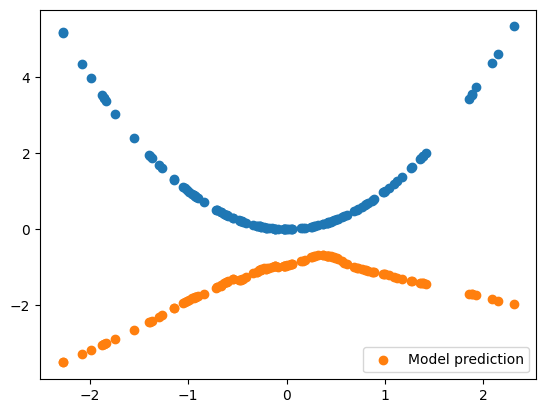

In [5]:
# Test our function locally 
pytree_examples()
common_pytree_functions()
ml_model()
custom_pytree_nodes()
gotchas()
patterns()

In [6]:
# Submit the function for code execution
result = data_scientist_client.api.services.code.request_code_execution(pytree_examples)
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.request_code_execution(common_pytree_functions)
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.request_code_execution(ml_model)
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.request_code_execution(custom_pytree_nodes)
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.request_code_execution(gotchas)
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.request_code_execution(patterns)
assert not isinstance(result, sy.SyftError)

## Part 2 - Data Owner Reviewing and Approving Requests

In [7]:
data_owner_client = node.login(email="info@openmined.org", password="changethis")

In [8]:
# Get messages from domain
messages = data_owner_client.api.services.messages.get_all()
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,8cc2984a14824accb7bf6536f225aa69,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 06:31:25,<<class 'syft.service.request.request.Request'...
1,syft.service.message.messages.Message,4f553903a2e24dfcb9161d4cc6fa78d8,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 06:31:25,<<class 'syft.service.request.request.Request'...
2,syft.service.message.messages.Message,f5cd890fcfcf425c8f2ce7fe7e079217,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 06:31:25,<<class 'syft.service.request.request.Request'...
3,syft.service.message.messages.Message,88af76c061ba4983807c97d0c1672a56,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 06:31:25,<<class 'syft.service.request.request.Request'...
4,syft.service.message.messages.Message,f065cb80907d4298af54ebf1c94772a6,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 06:31:25,<<class 'syft.service.request.request.Request'...


common_pytree_functions
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def common_pytree_functions():
    list_of_lists = [
        [1, 2, 3],
        [1, 2],
        [1, 2, 3, 4]
    ]

    list_tree_map = jax.tree_map(lambda x: x*2, list_of_lists)
    
    another_list_of_lists = list_of_lists
    another_list_tree_map = jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)
    return list_tree_map, another_list_tree_map

syft.service.code.user_code.UserCodeExecutionResult


exec_result=syft.service.code.user_code.UserCodeExecutionResult
action_object=Pointer:
syft.service.code.user_code.UserCodeExecutionResult


message='Request 47bbc5d68af84a4bbaae36ff5346d996 changes applied'
gotchas
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def gotchas():
    import jax
    import jax.numpy as jnp
    a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

    # Try to make another tree with ones instead of zeros
    shapes = jax.tree_map(lambda x: x.shape, a_tree)
    print(jax.tree_map(jnp.ones, shapes))
    print(jax.tree_util.tree_leaves([None, None, None]))

syft.service.code.user_code.UserCodeExecutionResult


exec_result=syft.service.code.user_code.UserCodeExecutionResult
action_object=Pointer:
syft.service.code.user_code.UserCodeExecutionResult


message='Request 7c334c133d2e41c6bf4765c5c425de4e changes applied'
pytree_examples
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def pytree_examples():
    import jax
    import jax.numpy as jnp

    example_trees = [
        [1, 'a', object()],
        (1, (2, 3), ()),
        [1, {'k1': 2, 'k2': (3, 4)}, 5],
        {'a': 2, 'b': (2, 3)},
        jnp.array([1, 2, 3]),
    ]

    # Let's see how many leaves they have:
    for pytree in example_trees:
        leaves = jax.tree_util.tree_leaves(pytree)
        print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

syft.service.code.user_code.UserCodeExecutionResult


exec_result=syft.service.code.user_code.UserCodeExecutionResult
action_object=Pointer:
syft.service.code.user_code.UserCodeExecutionResult


message='Request cd5e9b8fd33e42ed9057606f3fbd27a1 changes applied'
ml_model
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def ml_model():
    import numpy as np
    import jax
    import jax.numpy as jnp

    def init_mlp_params(layer_widths):
        params = []
        for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
            params.append(
                dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                    biases=np.ones(shape=(n_out,))
                    )
            )
        return params

    params = init_mlp_params([1, 128, 128, 1])
    print("Shapes:\n", jax.tree_map(lambda x: x.shape, params))

    def forward(params, x):
        *hidden, last = params
        for layer in hidden:
            x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
        return x @ last['weights'] + last['biases']

    def loss_fn(params, x, y):
        return jnp.mean((f

exec_result=syft.service.code.user_code.UserCodeExecutionResult
action_object=Pointer:
syft.service.code.user_code.UserCodeExecutionResult


message='Request 5e4cc586859d45ca902e91be523afd34 changes applied'
patterns
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def patterns():
    def tree_transpose(list_of_trees):
        """Convert a list of trees of identical structure into a single tree of lists."""
        return jax.tree_map(lambda *xs: list(xs), *list_of_trees)


    # Convert a dataset from row-major to column-major:
    episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
    print(tree_transpose(episode_steps))
    
    print(jax.tree_transpose(
        outer_treedef = jax.tree_structure([0 for e in episode_steps]),
        inner_treedef = jax.tree_structure(episode_steps[0]),
        pytree_to_transpose = episode_steps
    ))

syft.service.code.user_code.UserCodeExecutionResult


exec_result=syft.service.code.user_code.UserCodeExecutionResult
action_object=Pointer:
syft.service.code.user_code.UserCodeExecutionResult


message='Request 51adbf684b134b9993ae01601a7de87f changes applied'
custom_pytree_nodes
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def custom_pytree_nodes():
    import jax
    class MyContainer:
        """A named container."""

        def __init__(self, name: str, a: int, b: int, c: int):
            self.name = name
            self.a = a
            self.b = b
            self.c = c
    print(jax.tree_util.tree_leaves([
            MyContainer('Alice', 1, 2, 3),
            MyContainer('Bob', 4, 5, 6)
        ]))
    
    try:
        print(jax.tree_map(lambda x: x + 1, [
            MyContainer('Alice', 1, 2, 3),
            MyContainer('Bob', 4, 5, 6)
        ]))
    except Exception as e:
        print(e)
        
    from typing import Tuple, Iterable

    def flatten_MyContainer(container) -> Tuple[Iterable[int], str]:
        """Returns an iterable over container contents, and aux data."""
        flat_cont

exec_result=syft.service.code.user_code.UserCodeExecutionResult
action_object=Pointer:
syft.service.code.user_code.UserCodeExecutionResult


message='Request fcbbda05971046f5a4fbf3e0d7778528 changes applied'


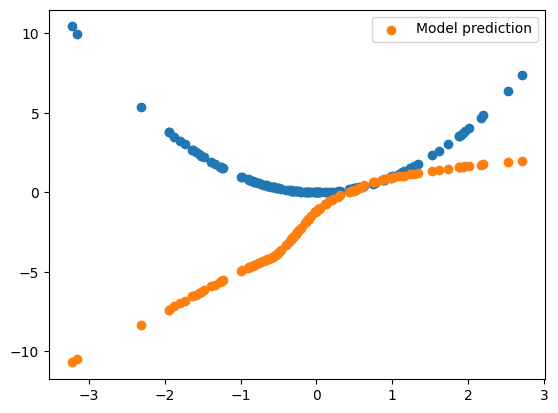

In [9]:
from helpers import review_request, run_submitted_function, accept_request

for message in messages:
    review_request(message)
    real_result = run_submitted_function(message)
    accept_request(message, real_result)

## Part 3 - Downloading the Results

### Tutorial complete 👏

In [10]:
result = data_scientist_client.api.services.code.pytree_examples()
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.common_pytree_functions()
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.ml_model()
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.custom_pytree_nodes()
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.gotchas()
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.patterns()
assert not isinstance(result, sy.SyftError)

In [11]:
if node.node_type.value == "python":
    node.land()